In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [5]:
INPUT_PATH = "../../data/CollegeMsg/dataset-collegeMsg.pk"

Load the dataset

In [6]:
dataset = Dataset.from_pickle(INPUT_PATH)

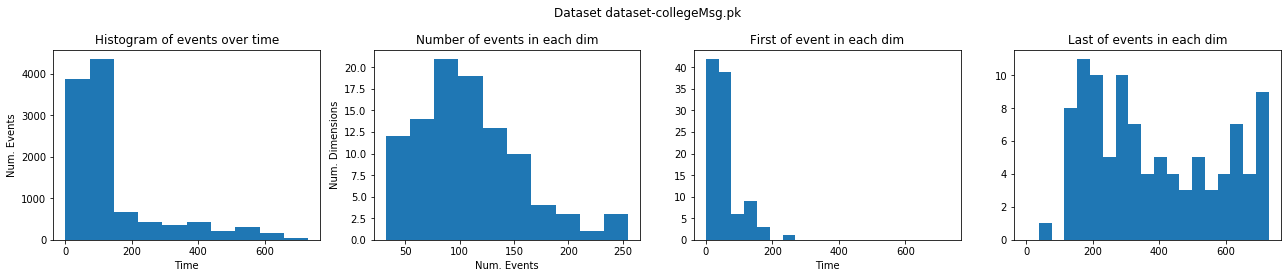

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(22, 3.5))

axs[0].hist(np.hstack(dataset.timestamps))
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Num. Events')
axs[0].set_title('Histogram of events over time')

axs[1].hist(list(map(len, dataset.timestamps)))
axs[1].set_xlabel('Num. Events')
axs[1].set_ylabel('Num. Dimensions')
axs[1].set_title('Number of events in each dim')


end_time = max(map(max, dataset.timestamps))
axs[2].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_title('First of event in each dim')
axs[2].set_xlabel('Time')

axs[3].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[3].set_title('Last of events in each dim')
axs[2].set_xlabel('Time')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}", y=1.05);

Print statistics of the dataset

In [8]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 10,869
               %NZ: 16.80%

Stats. of num. of events per dim:
count    100.000000
mean     108.690000
std       48.823884
min       32.000000
25%       73.000000
50%      103.500000
75%      134.000000
max      255.000000
dtype: float64


In [9]:
min_time = min(map(min, dataset.timestamps))
dataset.timestamps = [ev - min_time for ev in dataset.timestamps]

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       0.243431
std        0.546348
min        0.007862
25%        0.017921
50%        0.045320
75%        0.150446
max        3.527712
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean         6.783827
std         17.570936
min          0.000000
25%          0.060752
50%          0.943857
75%          2.984921
max        162.867966
dtype: float64



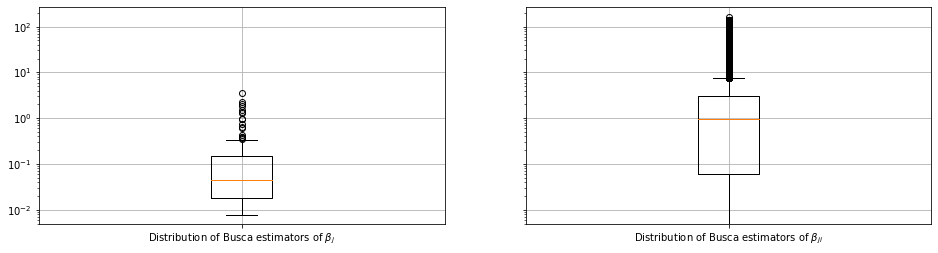

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

Build ground truth adjacency matrix

In [11]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

In [12]:
events = dataset.timestamps
end_time = dataset.end_time

---

## Run inference

---

### Run BBVI

In [28]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                   # baseline
    -2.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
     0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(1.0 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(1.0 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e2

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    params_mode = model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()
    beta_mode = params_mode[dim:-dim**2]
    adj_mode = params_mode[-dim**2:]
    return adj_mode / beta_mode


class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __call__(self, learner_obj, end=None, force=False):
        super().__call__(learner_obj, end, force)
        t = learner_obj._n_iter_done + 1
        if (t % self.print_every == 0) or force:
            coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
            mu_hat = coeffs_hat[:dim]
            beta_hat = coeffs_hat[dim:dim+dim**2]
            adj_hat = coeffs_hat[dim+dim**2:]
            print(f'   mu --> min: {mu_hat.min():.2e}, median: {np.median(mu_hat):.2e}, max: {mu_hat.max():.2e}')
            print(f' beta --> min: {beta_hat.min():.2e}, median: {np.median(beta_hat):.2e}, max: {beta_hat.max():.2e}')
            print(f'  adj --> min: {adj_hat.min():.2e}, median: {np.median(adj_hat):.2e}, max: {adj_hat.max():.2e}', flush=True)

# Set the callback (callback parameters are posterior mode)
callback = MyCallback(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=50,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')


# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

iter:    50 | dx: +3.2212e+08 | loss: 3.2145e+05 | dloss: -1.30e+05 | acc: 0.18 | f1-score: 0.28 | relerr: 4.62e+06 | p@5: 0.40 | p@10: 0.20 | p@20: 0.10 | time/it: 8.22e-02     
   mu --> min: 6.06e-03, median: 8.16e-03, max: 1.06e-02
 beta --> min: 1.62e-10, median: 6.44e-02, max: 8.00e+00
  adj --> min: 3.01e-03, median: 9.63e-02, max: 1.13e+01
iter:   100 | dx: +6.9433e+02 | loss: 7.7135e+04 | dloss: +1.79e+04 | acc: 0.27 | f1-score: 0.27 | relerr: 3.67e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.30e-02     
   mu --> min: 3.13e-03, median: 4.18e-03, max: 6.73e-03
 beta --> min: 1.03e-05, median: 1.93e-01, max: 1.72e+01
  adj --> min: 3.44e-03, median: 5.84e-02, max: 3.45e+01
iter:   150 | dx: +1.0354e+02 | loss: 6.3127e+04 | dloss: +1.62e+04 | acc: 0.37 | f1-score: 0.26 | relerr: 3.56e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.05 | time/it: 8.21e-02     
   mu --> min: 2.17e-03, median: 2.72e-03, max: 5.28e-03
 beta --> min: 1.20e-05, median: 3.11e-01, max: 1.73e+01
  adj -

   mu --> min: 1.07e-03, median: 1.73e-03, max: 6.23e-03
 beta --> min: 2.30e-04, median: 1.73e+00, max: 1.03e+02
  adj --> min: 1.07e-03, median: 1.28e-02, max: 2.43e+02
iter:  1250 | dx: +6.9689e+01 | loss: 3.6085e+04 | dloss: -4.62e+04 | acc: 0.70 | f1-score: 0.16 | relerr: 1.64e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 8.37e-02     
   mu --> min: 6.50e-04, median: 1.68e-03, max: 5.50e-03
 beta --> min: 2.30e-04, median: 1.62e+00, max: 1.13e+02
  adj --> min: 1.05e-03, median: 1.26e-02, max: 3.69e+02
iter:  1300 | dx: +2.9517e+01 | loss: 4.1028e+04 | dloss: +6.06e+03 | acc: 0.70 | f1-score: 0.16 | relerr: 1.46e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 8.22e-02     
   mu --> min: 9.64e-04, median: 1.76e-03, max: 6.91e-03
 beta --> min: 2.31e-04, median: 1.62e+00, max: 1.13e+02
  adj --> min: 9.59e-04, median: 1.24e-02, max: 3.26e+02
iter:  1350 | dx: +1.5124e+01 | loss: 4.4874e+04 | dloss: +7.62e+03 | acc: 0.70 | f1-score: 0.16 | relerr: 1.45e+02 | p@5: 0.00 |

iter:  2400 | dx: +8.0493e+01 | loss: 5.8389e+04 | dloss: -7.58e+04 | acc: 0.75 | f1-score: 0.13 | relerr: 2.19e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.15 | time/it: 8.15e-02     
   mu --> min: 1.05e-03, median: 1.93e-03, max: 1.55e-02
 beta --> min: 2.46e-04, median: 5.47e-01, max: 3.82e+02
  adj --> min: 2.88e-04, median: 2.79e-03, max: 3.95e+02
iter:  2450 | dx: +4.9118e+01 | loss: 6.0360e+04 | dloss: -2.10e+05 | acc: 0.75 | f1-score: 0.13 | relerr: 1.97e+02 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 8.07e-02     
   mu --> min: 1.01e-03, median: 1.97e-03, max: 2.40e-02
 beta --> min: 2.48e-04, median: 4.98e-01, max: 3.80e+02
  adj --> min: 2.41e-04, median: 2.56e-03, max: 2.78e+02
iter:  2500 | dx: +5.8427e+01 | loss: 6.0341e+04 | dloss: -5.44e+03 | acc: 0.75 | f1-score: 0.13 | relerr: 1.95e+02 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 8.10e-02     
   mu --> min: 8.68e-04, median: 1.91e-03, max: 2.59e-02
 beta --> min: 2.77e-04, median: 4.88e-01, max: 3.42e+02
  adj -

   mu --> min: 4.54e-04, median: 1.24e-03, max: 4.34e-02
 beta --> min: 3.20e-04, median: 1.71e-01, max: 3.82e+02
  adj --> min: 7.15e-06, median: 5.57e-04, max: 3.15e+02
iter:  3600 | dx: +1.6689e+02 | loss: 8.9331e+04 | dloss: +6.01e+03 | acc: 0.76 | f1-score: 0.14 | relerr: 6.61e+02 | p@5: 0.20 | p@10: 0.20 | p@20: 0.20 | time/it: 9.85e-02     
   mu --> min: 5.43e-04, median: 1.30e-03, max: 4.68e-02
 beta --> min: 3.21e-04, median: 1.68e-01, max: 4.51e+02
  adj --> min: 7.23e-06, median: 5.32e-04, max: 2.66e+02
iter:  3650 | dx: +1.1833e+02 | loss: 1.4265e+05 | dloss: +5.70e+04 | acc: 0.76 | f1-score: 0.14 | relerr: 7.54e+02 | p@5: 0.20 | p@10: 0.20 | p@20: 0.25 | time/it: 1.00e-01     
   mu --> min: 4.54e-04, median: 1.27e-03, max: 4.29e-02
 beta --> min: 3.22e-04, median: 1.54e-01, max: 3.87e+02
  adj --> min: 6.04e-06, median: 4.85e-04, max: 3.00e+02
iter:  3700 | dx: +2.2698e+02 | loss: 8.7601e+04 | dloss: +1.82e+03 | acc: 0.76 | f1-score: 0.13 | relerr: 7.29e+02 | p@5: 0.40 |

KeyboardInterrupt: 

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
mu_hat = coeffs_hat[:dim]
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()]);
plt.title(f'Method {type(model).__name__}')

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

experiments_utils.print_report(name=type(model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.02)

---

### Run VI

In [27]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.01 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.01
variance
0.01
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [14]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [15]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

iter:    10 | dx: +8.2118e-01 | f1-score: 0.17 | relerr: 2.88e+00 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 3.63e+00     
iter:    20 | dx: +1.9519e-01 | f1-score: 0.14 | relerr: 2.75e+00 | p@5: 0.20 | p@10: 0.20 | p@20: 0.15 | time/it: 2.56e-01     
iter:    30 | dx: +5.1126e-02 | f1-score: 0.13 | relerr: 2.69e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 2.43e-01     
iter:    40 | dx: +4.7639e-02 | f1-score: 0.12 | relerr: 2.67e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 2.47e-01     
iter:    50 | dx: +2.5249e-02 | f1-score: 0.12 | relerr: 2.65e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 2.52e-01     
iter:    60 | dx: +2.3562e-02 | f1-score: 0.12 | relerr: 2.65e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 2.43e-01     
iter:    70 | dx: +3.8552e-02 | f1-score: 0.12 | relerr: 2.65e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.15 | time/it: 2.42e-01     
iter:    80 | dx: +1.3648e-02 | f1-score: 0.12 | relerr: 2.65e+00 | p@5: 0.00 | p@10: 0.20 | p@20

KeyboardInterrupt: 

In [38]:
alpha_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

adj_hat = alpha_hat
#adj_hat = alpha_hat / beta_hat

#adj_hat[np.eye(len(adj_hat)).astype(bool)] = 0.0

experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.001)


========== Method: WoldModelVariational

Accuracy: 0.75

Edge counts
------------
Pred: 1104.00
True: 1680.00

Error counts
------------
 True Positive: 154.00
False Positive: 950.00
 True Negative: 7370.00
False Negative: 1526.00

Error rates
-----------
 True Positive Rate: 0.09
False Positive Rate: 0.11
 True Negative Rate: 0.89
False Negative Rate: 0.91

F-Score
-------
 F1-Score: 0.11
Precision: 0.14
   Recall: 0.09

Precision@k
-----------
  Prec@5: 0.00
 Prec@10: 0.20
 Prec@20: 0.15
 Prec@50: 0.20
Prec@100: 0.25
Prec@200: 0.28

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.04400000000000001
10 0.063
20 0.07949999999999996
50 0.10980000000000001
100 0.16800000000000007
200 0.08400000000000003



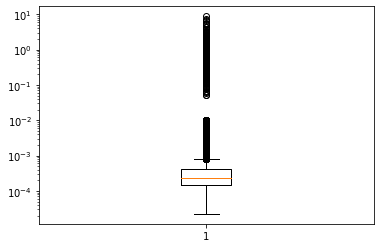

In [30]:
plt.boxplot(adj_hat.flatten());
plt.yscale('log');

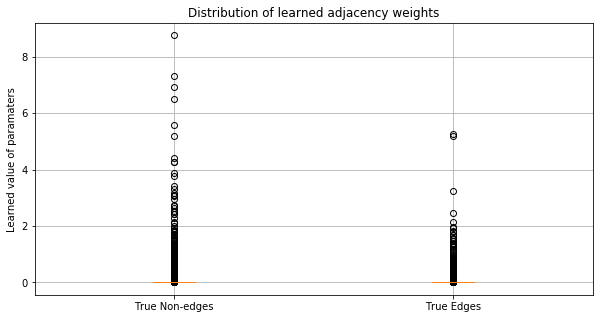

In [31]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0]],
    labels=['True Non-edges', 'True Edges'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

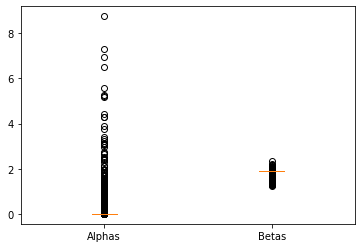

In [32]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()], labels=['Alphas', 'Betas']);

---

### Run GB

In [46]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [48]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

adj_hat = adj_hat / beta_hat  # Does not matter


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=type(granger_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.17

Edge counts
------------
Pred: 386.00
True: 1680.00

Error counts
------------
 True Positive: 104.00
False Positive: 282.00
 True Negative: 8038.00
False Negative: 1576.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.03
 True Negative Rate: 0.97
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.10
Precision: 0.27
   Recall: 0.06

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.26799999999999974
10 0.2540000000000001
20 0.17700000000000002



In [161]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

0.7420330871354197

In [180]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=-0.03233722944985986, pvalue=0.0005001328376041202)

In [166]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

-0.039862506938532154

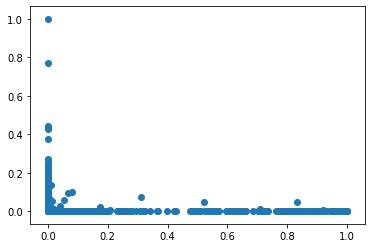

In [167]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [181]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [182]:
mean_rank_corr

-0.039862506938532154

(array([ 6., 17., 24., 15., 12.,  7.,  8.,  4.,  3.,  4.]),
 array([-0.16471, -0.13208, -0.09946, -0.06683, -0.0342 , -0.00158,  0.03105,  0.06367,  0.0963 ,  0.12893,  0.16155]),
 <a list of 10 Patch objects>)

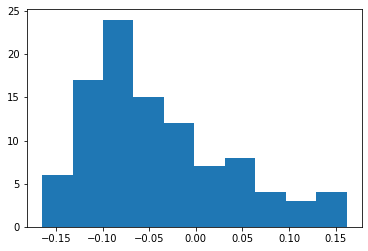

In [183]:
plt.hist(rank_corr_per_dim)

In [172]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

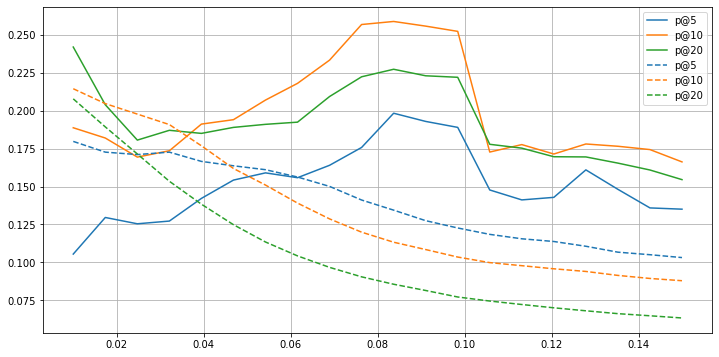

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();